# Logistic Regression with Bank Data

## Goals

- we will attempt to predict loan status from the bank database
- we are using a logstic regression model with binary classification
- we are expecting low accuracy

## Imports

In [46]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

## Getting the data from SQL

In [47]:
import getpass

In [48]:
password = getpass.getpass()

In [49]:
connection_string = 'mysql+pymysql://root:' + password + '@127.0.0.1/bank'
engine = create_engine(connection_string)

In [50]:
df = pd.read_sql_query('''
SELECT t.type, t.operation, t.amount AS t_amount, 
t.balance, t.k_symbol, 
l.amount AS l_amount, l.duration, 
l.payments, l.status
FROM trans t 
LEFT JOIN loan l USING(account_id);
''', engine)

## EDA and Data cleaning

In [51]:
df.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None


In [52]:
df.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

### dealing with nulls

In [53]:
# another way
# df[df['duration'].isna() == False]

In [54]:
# filter out null values
df = df[~df['duration'].isna()]

In [55]:
df.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156081 entries, 62 to 868011
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   type       156081 non-null  object 
 1   operation  156081 non-null  object 
 2   t_amount   156081 non-null  float64
 3   balance    156081 non-null  float64
 4   k_symbol   156081 non-null  object 
 5   l_amount   156081 non-null  float64
 6   duration   156081 non-null  float64
 7   payments   156081 non-null  float64
 8   status     156081 non-null  object 
dtypes: float64(5), object(4)
memory usage: 11.9+ MB


### turning duration into object

In [57]:
df['duration'] = df['duration'].astype('object')

### cleaning categorical data

#### cleaning operation

In [58]:
df['operation'].value_counts()

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64

In [59]:
def clean_op(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

In [60]:
df['operation']= df['operation'].apply(clean_op)

#### cleaning k_symbol


In [61]:
df['k_symbol'].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', 'UVER', ' ', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [62]:
def clean_k_sym(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [63]:
df['k_symbol'] = df['k_symbol'].apply(clean_k_sym)

In [64]:
df['k_symbol'].value_counts()

unknown        79925
UROK           31337
SLUZBY         23592
SIPO           10482
UVER            7744
POJISTNE        2412
SANKC. UROK      589
Name: k_symbol, dtype: int64

In [65]:
df= df[~df['k_symbol'].isin(['UVER','POJISTNE','SANKC. UROK'])]

#### cleaning operation

In [66]:
def clean_type(x):
    if 'PRI' in x:
        return 'PRIJEM'
    else:
        return x

In [67]:
df['type'] = df['type'].apply(clean_type)

In [68]:
df['type'].value_counts()

VYDAJ     80683
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

In [69]:
df.reset_index(drop=True, inplace=True)

### investigating numeric data

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

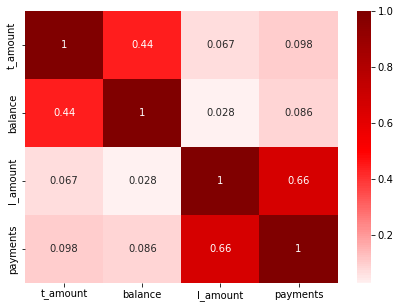

In [71]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), cmap='seismic', center=0, annot=True);

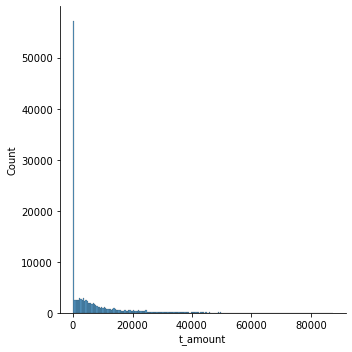

In [72]:
sns.displot(df['t_amount']);

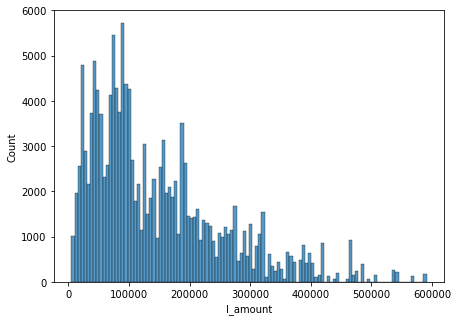

In [73]:
plt.figure(figsize=(7,5))
sns.histplot(df['l_amount']);

In [74]:
df['t_amount'].describe()

count    145336.000000
mean       8127.276145
std       12047.666621
min           0.000000
25%         133.800000
50%        2758.000000
75%       11000.000000
max       87300.000000
Name: t_amount, dtype: float64

In [75]:
df['l_amount'].describe()

count    145336.000000
mean     146015.695162
std      109476.855709
min        4980.000000
25%       65184.000000
50%      110736.000000
75%      200976.000000
max      590820.000000
Name: l_amount, dtype: float64

## Normalizing

In [76]:
import numpy as np
from sklearn.preprocessing import Normalizer

In [77]:
X = df.select_dtypes(include = np.number)

In [78]:
transformer = Normalizer()
# transformer.fit(X) what's the point?
x_normalised = transformer.transform(X)

In [79]:
x = pd.DataFrame(x_normalised, columns=X.columns)

In [80]:
x

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007
...,...,...,...,...
145331,0.000253,0.063358,0.997852,0.016631
145332,0.000426,0.096119,0.995232,0.016587
145333,0.000481,0.113176,0.993437,0.016557
145334,0.000706,0.152565,0.988156,0.016469


In [81]:
def good_bad(x):
    if x in ['A', 'C']:
        return 1
    else:
        return 0

### defining new column: new status to make binary

In [82]:
# another way
# df['new_status'] = df['status'].apply(good_bad)

In [83]:
df['new_status'] = df['status'].apply(lambda x: 1 if x in ['A', 'C'] else 0)

In [84]:
df['new_status'].value_counts()

# risk of amplification of the majority class
# becuase the model is better is predicting the majority class

# sampling techniques
# normally done after the first analysis

# oversampling - adding values to minority
# undersampling - reducing majority values

1    127747
0     17589
Name: new_status, dtype: int64

In [85]:
cat = df.select_dtypes(include='object')

In [86]:
#getting rid of status, cus that's the target??
cat = cat.drop(['status'], axis=1)

In [87]:
# getting dummies

categorical = pd.get_dummies(cat, columns = ['type', 'operation', 'k_symbol', 'duration'], drop_first = True)

## Modelling - Candidate Model 1

In [88]:
x.head()

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007


In [128]:
categorical.head()

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_24.0,duration_36.0,duration_48.0,duration_60.0
0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0


In [90]:
# getting labels 
y = df['new_status']

In [91]:
# now concatenate dfs
len(x), len(y), len(df)

(145336, 145336, 145336)

In [93]:
x_full = pd.concat([x, categorical], axis=1)

### creating the model

In [108]:
# imports
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [104]:
lr = LogisticRegression(max_iter = 400)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(x_full, y, test_size=0.3, random_state=40)

In [122]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=400)

### testing the model

In [123]:
y_pred = lr.predict(X_test)
accuracy_score(y_test ,y_pred)

0.882227471846976

In [124]:
confusion_matrix(y_test, y_pred)

array([[  201,  5031],
       [  104, 38265]])

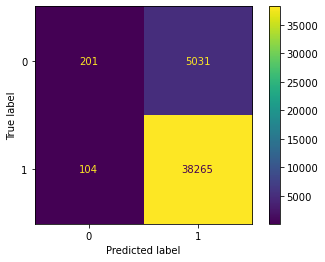

In [125]:
plot_confusion_matrix(lr, X_test, y_test);

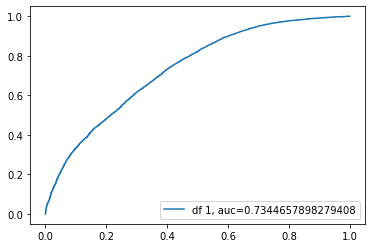

In [126]:
# area under the curve

import sklearn.metrics as metrics
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label='df 1, auc='+str(auc))
plt.legend(loc=4);